Presenting the best developed model so far (max `val_categorical_accuracy` = 0.7713).
<br> <br>
Input pipeline includes **handcrafted cloud detection**  (see *Images preprocessing* section) which either discards or preprocesses multispectral images with noticeable amount of clouds (see *clouds_shadows* notebook for visual examples). 
<br>
Future versions of the input pipeline will include **Haralick feautures calculation** and **data augmentation**.
<br> <br>
<font color = 'gray'> NOTE: the present notebook was originally run using Google Drive and Google Colab GPUs. </font>

In [1]:
! nvidia-smi

Sat Mar 27 13:49:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports, drive mounting, defining constants

In [2]:
import tensorflow as tf
import numpy as np

# images
import cv2
import skimage.transform # for scaling multichannel (>3) images
from skimage.feature import greycomatrix, greycoprops

# utils
from os import listdir
from google.colab import drive
import random

In [ ]:
drive.mount('/content/drive')

In [4]:
LOAD_PATH = '/content/drive/My Drive/data/'
SAVE_PATH = '/content/drive/My Drive/saved/'

ORIGIN_IMG_DIM = 65 
BANDS = ['B4', 'B3', 'B2', 'B5', 'B6', 'B10', 'B11']
NUM_CLASSES = 4 # 0, 1, 2, 3; 4 will be used temporarily when marking samples to discard (on account of clouds) 

# model training
LR = 1.0 # Adadelta
BATCH_SIZE = 64 
NUM_EPOCHS = 80
BUFF_SIZE = BATCH_SIZE * 8 # for input stream (dataset.shuffle()), 'In practice, we use buffer size equals to several batch sizes.'

### Images preprocessing 

In [5]:
# preprocesses multispectral image regarding clouds
def preprocess_clouds(multispec_img, seg_img): # takes (single img from minibatch along with binary clouds / no clouds image)
  if np.sum(seg_img) / (65 * 65) <= 0.05: # clouds constitute no more than 5% of an image, it's okay
    return multispec_img, None 

  # use four sliding 50x50 windows to pick the part with the least clouds
  # slices numbers spatially:
  # 0 1 
  # 2 3
  slices = {
    0 : (slice(0, 50), slice(0, 50)),
    1 : (slice(0, 50), slice(15, 65)),
    2 : (slice(15, 65), slice(0, 50)),
    3 : (slice(15, 65), slice(15, 65)),
  }

  cloud_areas = np.zeros((4, ), dtype = int)

  # TODO: vectorize
  for i in range(4):
    cloud_areas[i] = np.sum(seg_img[slices[i]])

  min_quart = np.argmin(cloud_areas)
  if cloud_areas[min_quart] / (50 * 50)  <= 0.1: # if the best 50x50 slice contains less than 10% clouds
    return skimage.transform.resize(multispec_img[slices[min_quart]], (65, 65), preserve_range = True), slices[min_quart]

  # there's still to many clouds 
  return None

# function preproccesing and returing a new image (and new label if marked)
def preprocess_sample(multispec_img, label): 
  # global TIRs channels min & max for clouds detection
  tirs_min = 153
  tirs_max = 215

  if multispec_img[:, :, 0 : 3].max() == 0: # some images seems to be corrupted (all black)
    return multispec_img, np.int32(4)

  tirs_mean = (multispec_img[:, :, 5].astype(np.int16) + multispec_img[:, :, 6].astype(np.int16)) / 2
  tirs_mean_norm = (tirs_mean - tirs_min) / (tirs_max - tirs_min)

  single_chan_img = np.zeros((ORIGIN_IMG_DIM, ORIGIN_IMG_DIM), dtype = np.int16) 
  single_chan_img = multispec_img[:, :, 2] - tirs_mean_norm # BLUE - TIRs

  # binary clouds / no clouds image
  single_chan_img[single_chan_img < 50] = 0
  single_chan_img[single_chan_img >= 50] = 1

  tup = preprocess_clouds(multispec_img, single_chan_img)

  if tup is None:
    return multispec_img, np.int32(4) # discard on account of clouds
  (multispec_img_no_clouds, slices) = tup  

  return multispec_img_no_clouds.astype(np.uint8), label

def scale_bands(multispec_img):
  scaled_multispec_img = multispec_img / 255.

  return scaled_multispec_img.astype(np.float32)

### Data loading and synthesizing

In [6]:
def filelist_from_folder(folder): # returns list of all TFRecords files inside a specified folder
  folder_path = LOAD_PATH + folder + '/'
  paths_list = []

  for filename in listdir(folder_path):
    if filename.startswith('part-') and not filename.endswith('gstmp'):
      paths_list.append(folder_path + filename)

  random.shuffle(paths_list) # make sure there's no order
  return paths_list

In [7]:
# what features to extract from TFRecord
features = {
  'B2': tf.io.FixedLenFeature([], tf.string), # B
  'B3': tf.io.FixedLenFeature([], tf.string), # G
  'B4': tf.io.FixedLenFeature([], tf.string), # R
  'B5': tf.io.FixedLenFeature([], tf.string), # NIR
  'B6': tf.io.FixedLenFeature([], tf.string), # SWIR1
  'B7': tf.io.FixedLenFeature([], tf.string), # SWIR2
  'B10': tf.io.FixedLenFeature([], tf.string), # TIR1
  'B11': tf.io.FixedLenFeature([], tf.string), # TIR2
  'label': tf.io.FixedLenFeature([], tf.int64)}  

In [8]:
def getband(example_key): # returns one channel, (65, 65, 1) tensor
  img = tf.io.decode_raw(example_key, tf.uint8) 

  return tf.reshape(img[ : ORIGIN_IMG_DIM**2], shape = (ORIGIN_IMG_DIM, ORIGIN_IMG_DIM, 1)) 

def _parse_(serialized_example, keylist):
  example = tf.io.parse_single_example(serialized_example, features) # transforms serialized binary sequence to a dictionary with
                                                                     # assigned sequences
  bandlist = [getband(example[key]) for key in keylist]
  image = tf.concat(bandlist, -1) # join all channels
  label = tf.cast(example['label'], tf.int32) 

  # clouds preprocessing + mark samples to discard with 4
  [image, label] = tf.numpy_function(preprocess_sample, [image, label], [tf.uint8, tf.int32])

  # scaling
  image = tf.numpy_function(scale_bands, [image], tf.float32)

  if label == 4: 
    return image, tf.convert_to_tensor([1., 1., 1., 1.]) # will be used later in dataset.filter() method

  label = tf.one_hot(label, NUM_CLASSES)
  return image, label 

def parse_tfrecords(paths_list, buff_size): 
  dataset = tf.data.TFRecordDataset(paths_list) 
  dataset = dataset.shuffle(buff_size, reshuffle_each_iteration = True)
  dataset = dataset.map(lambda x : _parse_(x, BANDS), num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.filter(lambda x, y : tf.math.reduce_sum(y) != 4.) # discard corrupted / cloudy samples
  dataset = dataset.batch(BATCH_SIZE) 
  dataset = dataset.prefetch(tf.data.AUTOTUNE) # load new samples into buffer when training (increases speed)

  return dataset

In [9]:
train_tfrecords = filelist_from_folder('train')
val_tfrecords = filelist_from_folder('val')

train = parse_tfrecords(train_tfrecords, BUFF_SIZE)
val = parse_tfrecords(val_tfrecords, BUFF_SIZE)

### Custom loss function

In [10]:
def class_weights_matrix():
  class_weights = np.zeros((NUM_CLASSES, NUM_CLASSES))
  class_weights[:, 0] += 0.25
  class_weights[:, 1] += 1.7
  class_weights[:, 2] += 1.7
  class_weights[:, 3] += 2.5
  
  return class_weights

In [11]:
# stackoverlow
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
class WeightedCategoricalCrossentropy2(tf.keras.losses.CategoricalCrossentropy):

  def __init__(self, cost_mat, name='weighted_categorical_crossentropy', **kwargs):

    cost_mat = np.array(cost_mat)   
    ## when loading from config, self.cost_mat returns as a list, rather than an numpy array. 
    ## Adding the above line fixes this issue, enabling .ndim to call sucessfully. 
    ## However, this is probably not the best implementation
    assert(cost_mat.ndim == 2)
    assert(cost_mat.shape[0] == cost_mat.shape[1])
    super().__init__(name=name, **kwargs)
    self.cost_mat = K.cast_to_floatx(cost_mat)

  def __call__(self, y_true, y_pred, sample_weight=None):
    assert sample_weight is None, "should only be derived from the cost matrix"  
    return super().__call__(
        y_true=y_true, 
        y_pred=y_pred, 
        sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
    )

  def get_config(self):
    config = super().get_config().copy()
    # Calling .update on the line above, during assignment, causes an error with config becoming None-type.
    config.update({'cost_mat': (self.cost_mat)})
    return config

  @classmethod
  def from_config(cls, config):
    # something goes wrong here and changes self.cost_mat to a list variable.
    # See above for temporary fix
    return cls(**config)

def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    assert(y_pred.shape[1] == num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n

# Register the loss in the Keras namespace to enable loading of the custom object.
tf.keras.losses.WeightedCategoricalCrossentropy2 = WeightedCategoricalCrossentropy2

### Building and compiling the model

In [12]:
input = tf.keras.Input(shape = (65, 65, 7))

x = tf.keras.layers.Conv2D(64, 5, activation = 'relu')(input[:, :, :, 0 : 6])
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(128, 3, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(512, 3, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x) 
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(1024, activation = 'relu')(x) 
x = tf.keras.layers.BatchNormalization()(x)

output = tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax', )(x)

# define model
model = tf.keras.Model(inputs = input, outputs = output)
model.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate = LR), 
              loss = tf.keras.losses.WeightedCategoricalCrossentropy2(class_weights_matrix()), 
              metrics = ['categorical_accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65, 65, 7)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 65, 65, 6)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 64)        9664      
_________________________________________________________________
batch_normalization (BatchNo (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512   

### Training

In [13]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH, save_best_only = True,
                                                save_weights_only = True, monitor = 'val_categorical_accuracy')
csv_logger = tf.keras.callbacks.CSVLogger(SAVE_PATH + 'train_logs.csv', separator = ',', append = True)

history = model.fit(train, epochs = NUM_EPOCHS, validation_data = val, 
                    callbacks = [checkpoint, csv_logger], verbose = 1)

Epoch 1/80
1225/1225 [==============================] - 135s 104ms/step - loss: 1.1929 - categorical_accuracy: 0.5875 - val_loss: 0.7073 - val_categorical_accuracy: 0.5970
Epoch 2/80
1225/1225 [==============================] - 126s 103ms/step - loss: 0.6260 - categorical_accuracy: 0.6479 - val_loss: 4.9903 - val_categorical_accuracy: 0.1138
Epoch 3/80
1225/1225 [==============================] - 124s 101ms/step - loss: 0.6469 - categorical_accuracy: 0.6746 - val_loss: 0.6554 - val_categorical_accuracy: 0.6499
Epoch 4/80
1225/1225 [==============================] - 124s 101ms/step - loss: 0.6303 - categorical_accuracy: 0.6941 - val_loss: 1.3619 - val_categorical_accuracy: 0.5727
Epoch 5/80
1225/1225 [==============================] - 120s 98ms/step - loss: 0.6185 - categorical_accuracy: 0.7084 - val_loss: 0.8236 - val_categorical_accuracy: 0.6792
Epoch 6/80
1225/1225 [==============================] - 122s 100ms/step - loss: 0.6044 - categorical_accuracy: 0.7170 - val_loss: 0.5829 - va

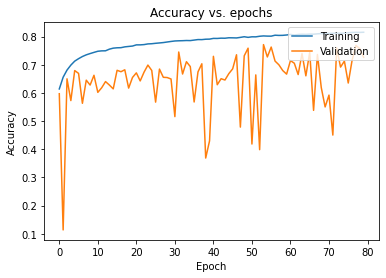

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right');

plt.savefig(SAVE_PATH + 'history.png')